In [ ]:
!unzip "/content/archive (18).zip"

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision
import torch.optim as optim
import transformers
import torchvision.models as models
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
from torch.optim import Adam
from tqdm  import tqdm
from transformers import ViTFeatureExtractor, ViTModel, ViTConfig

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
print(transformers.__version__)

4.47.1


In [ ]:
df = pd.read_csv("/content/captions.txt", sep=",", header=None,
                 names=["image", "caption"])

In [ ]:
df.head()

,image,caption
0,image,caption
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...


In [ ]:
image_path=[]
for i in df['image']:
    image_path.append('/content/Images/'+i)

In [ ]:
caption=[]
for i in df['caption']:
    caption.append(i)
print(caption[0])

caption


In [ ]:
image_path=image_path[1:]
caption=caption[1:]

In [ ]:
image_path[0]

'/content/Images/1000268201_693b08cb0e.jpg'

caption: A child in a pink dress is climbing up a set of stairs in an entry way .


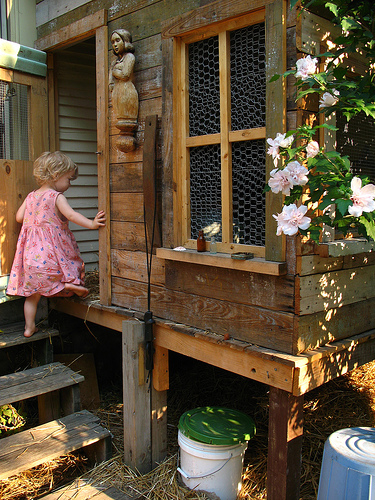

In [ ]:
from PIL import Image
import PIL
image=image_path[0]
image=Image.open(image)
print(f"caption: {caption[0]}")
image

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_path,caption, test_size=0.2, random_state=42)

In [ ]:
max_len=0
max_len_dis=[]
for i in y_train:
    #print(i)
    #print(len(i.split()))
    max_len_dis.append(len(i.split()))
    if len(i.split())>max_len:
        max_len=len(i.split())
max_len

34

In [ ]:
pos_word={}
c=0
for i in y_train:
    for j in i.split():
        if j not in pos_word:
            pos_word[j]=c
            c+=1
print(len(pos_word))
#pos_word

8743


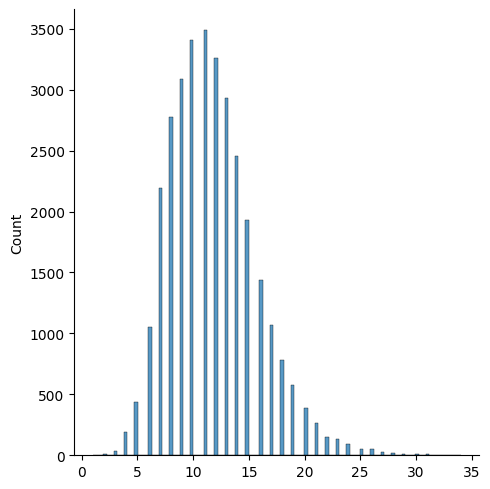

In [ ]:
sns.displot(max_len_dis)

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
 ])

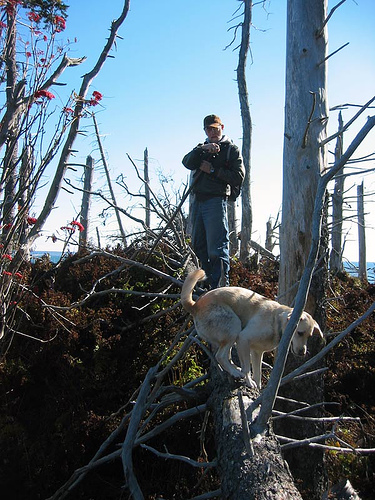

In [ ]:
org_image_path=X_train[0]
org_img=Image.open(org_image_path)
org_img

In [ ]:
print("normalize image")
#plt.imshow(sample_output['image_tensor'].squeeze().permute(1, 2, 0))

In [ ]:
model=T5ForConditionalGeneration.from_pretrained('t5-base',return_dict=True,)
tokenizer=T5TokenizerFast.from_pretrained('t5-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
class imageDataset(Dataset):
    def __init__(self,data,transform,training,lables=None):
        self.data=data
        self.lables=lables
        self.transform=transform
        self.training=training
        self.tokenizer=tokenizer
        self.max_len=max_len


    def __len__(self):
        return len(self.data)


    def __getitem__(self,index):
        image=self.data[index]
        image_1=Image.open(image)
        if self.training:
            caption=str(self.lables[index])
            caption=" ".join(caption.split())
            inputs=self.tokenizer(caption,
                                  max_length=self.max_len,
                                  add_special_tokens=True,
                                  padding='max_length',
                                  pad_to_max_length=True,
                                  truncation=True)
            labels=inputs['input_ids']
            labels[labels==0]=-100
            mask=inputs['attention_mask']
            #print(inputs)
            return {
                'image_tensor':self.transform(image_1),
                'labels':torch.tensor(labels,dtype=torch.long),
                'mask':torch.tensor(mask,dtype=torch.long),
                'decoder_input_ids':torch.tensor(mask,dtype=torch.long)
            }
        else:
            return {
                'image_tensor':self.transform(image_1),
                'labels':torch.tensor(labels,dtype=torch.long),
                'mask':torch.tensor(mask,dtype=torch.long),
                'decoder_input_ids':torch.tensor(mask,dtype=torch.long)

            }

In [ ]:
sample_data=imageDataset(data=X_train,transform=data_transforms,training=True,lables=y_train)


In [ ]:
sample_output=sample_data.__getitem__(0)

In [ ]:
sample_output

{'image_tensor': tensor([[[ 0.1426,  0.1083,  0.2111,  ...,  0.0912,  0.0569,  0.0569],
          [ 0.6221,  0.1254,  0.4851,  ...,  0.1254,  0.1083,  0.0912],
          [-0.1143, -0.4568, -0.3369,  ...,  0.1597,  0.1254,  0.1254],
          ...,
          [-1.9809, -1.9809, -1.9809,  ..., -1.9809, -1.9809, -2.0323],
          [-1.9980, -1.9980, -1.9980,  ..., -1.9467, -1.9809, -2.0152],
          [-1.9980, -1.9980, -1.9980,  ..., -1.8953, -1.9638, -1.9638]],
 
         [[-0.3725, -0.4601, -0.1450,  ...,  1.3606,  1.3256,  1.3256],
          [-0.0049, -0.3200,  0.1877,  ...,  1.3957,  1.3782,  1.3606],
          [-0.3025, -0.5651,  0.0126,  ...,  1.4307,  1.3957,  1.3957],
          ...,
          [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.9482],
          [-1.9132, -1.9132, -1.9132,  ..., -1.8431, -1.8957, -1.9307],
          [-1.9132, -1.9132, -1.9132,  ..., -1.8081, -1.8782, -1.8782]],
 
         [[-0.0615, -0.3055,  0.2522,  ...,  2.5877,  2.5529,  2.5529],
          [-

In [ ]:
train_data_custom=imageDataset(data=X_train,transform=data_transforms,training=True,lables=y_train)
test_data_custom=imageDataset(data=X_test,transform=data_transforms,training=False,lables=y_test)

In [ ]:
train_data_loader=DataLoader(dataset=train_data_custom,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=True
)
test_data_loader=DataLoader(dataset=test_data_custom,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False
)

In [ ]:
next(iter(train_data_loader))

{'image_tensor': tensor([[[[-1.2788,  0.5193,  0.7933,  ..., -1.2788, -0.3027, -0.9534],
           [-0.8335,  0.7933,  0.6734,  ..., -1.0733, -0.6109, -1.2103],
           [-0.4911,  1.1872,  0.7419,  ..., -1.1760, -1.2959, -1.5014],
           ...,
           [-1.6898, -1.6727, -1.6555,  ..., -1.4329, -1.4329, -1.4158],
           [-1.7583, -1.6727, -1.7069,  ..., -1.4158, -1.4158, -1.4158],
           [-1.7754, -1.7069, -1.6555,  ..., -1.4158, -1.4158, -1.3987]],
 
          [[-0.8803,  0.6779,  0.7129,  ..., -1.1604, -0.3901, -0.8978],
           [-0.4251,  0.9055,  0.5553,  ..., -0.8803, -0.5651, -1.1253],
           [-0.1625,  1.2031,  0.5903,  ..., -0.8978, -1.0728, -1.3354],
           ...,
           [-1.3880, -1.3704, -1.3529,  ..., -1.0378, -1.1078, -1.1253],
           [-1.4580, -1.3529, -1.4055,  ..., -1.0378, -1.0903, -1.1253],
           [-1.4755, -1.4055, -1.3529,  ..., -1.0553, -1.0903, -1.1078]],
 
          [[-0.2881,  0.9319,  1.1411,  ..., -1.2641, -0.6541, -1.2293

In [ ]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self,embed_size):
        super(EncoderDecoder,self).__init__()
        resnet=models.resnet50(pretrained=True)

        for parm in resnet.parameters():
            parm.requires_grad_(False)

        modules=list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

        #decoder: t5
        self.model=T5ForConditionalGeneration.from_pretrained('t5-base',return_dict=True)
        self.tokenizer=T5TokenizerFast.from_pretrained('t5-base')

    def forward(self, images,decoder_inputs_ids,attention_mask,labels):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        image_features = self.embed(features).unsqueeze(1)


        output=self.model(
            inputs_embeds=image_features,
            decoder_input_ids=decoder_inputs_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        return output.logits,output.loss


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
max_len=34
training_file=y_train
optimizer=Adam(model.parameters(),lr=0.00001)
epochs=5

In [ ]:
test_sample=next(iter(train_data_loader))
test_sample

In [ ]:
final_model=EncoderDecoder(embed_size=768)

In [ ]:
final_model.forward(test_sample['image_tensor'],test_sample['decoder_input_ids'],test_sample['mask'],test_sample['labels'])

(tensor([[[-32.5389, -19.7516, -21.6713,  ..., -67.4607, -67.1875, -67.3004],
          [-32.5389, -19.7516, -21.6713,  ..., -67.4607, -67.1875, -67.3004],
          [-32.5389, -19.7516, -21.6713,  ..., -67.4607, -67.1875, -67.3004],
          ...,
          [-26.6162, -23.4222, -22.6366,  ..., -65.2264, -64.9899, -65.1586],
          [-26.7014, -23.4640, -22.6808,  ..., -65.3203, -65.0851, -65.2536],
          [-26.7519, -23.4869, -22.7125,  ..., -65.3834, -65.1491, -65.3174]],
 
         [[-34.6604, -21.4402, -22.4021,  ..., -70.1332, -69.8671, -70.0124],
          [-34.6604, -21.4401, -22.4021,  ..., -70.1332, -69.8671, -70.0124],
          [-34.6604, -21.4401, -22.4021,  ..., -70.1332, -69.8671, -70.0124],
          ...,
          [-28.1038, -24.5141, -22.9903,  ..., -67.0549, -66.8515, -67.0338],
          [-28.1360, -24.5270, -23.0083,  ..., -67.0956, -66.8930, -67.0749],
          [-28.1675, -24.5405, -23.0263,  ..., -67.1364, -66.9346, -67.1161]],
 
         [[-32.1051, -19.946

In [ ]:
train_loss=0
val_loss=0
train_batch_count=0
val_batch_count=0

for epoch in range(epochs):
    final_model.train()
    for batch in tqdm(train_data_loader):
        #print(batch)
        input_ids=batch['image_tensor'].to(device)
        attention_mask=batch['mask'].to(device)
        labels=batch['labels'].to(device)
        decoder_input_ids=batch['decoder_input_ids'].to(device)
        #input_ids=input_ids.unsqueeze(1)  #[32,224]
        print(input_ids.shape)
        print(decoder_input_ids.shape)
        print(attention_mask.shape)
        print(labels.shape)
        output,loss=final_model(input_ids,decoder_input_ids,attention_mask,labels)
        #print(output)
        optimizer.zero_grad()
        #loss,_=output.loss
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        train_batch_count+=1

    print(f"Train Loss: {train_loss/train_batch_count}")

In [ ]:
final_model.eval()
for batch in tqdm(test_data_loader):
    inputs_ids=batch['image_tensor'].to(device)
    attention_mask=batch['mask'].to(device)
    labels=batch['labels'].to(device)
    decoder_input_ids=batch['decoder_input_ids'].to(device)
    with torch.no_grad():
        output,loss=model(inputs_ids,decoder_input_ids,attention_mask,labels)
        #loss=output.loss
        val_loss+=loss.item()
        val_batch_count+=1
print(f"Val Loss: {val_loss/val_batch_count}")